In [2]:
import pandas as pd
import numpy as np

# import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import json 




# Load the Dataset

# Da die Attributsnamen kodiert sind werden diese zu erst mithilfe der zugehörigen Dokumentation ersetzt. (Siehe Categorical.json)


In [3]:
file_path = "../German_Credit_data/Data/german.data"

names = ['Status Checking', 'Duration in Month', 'Credit History', 'Purpose', 'Credit Amount', 
         'Savings Account', 'Employement since', 'Installmentrate %', 'StatusSex', 'Otherdebtos', 
         'PresentResidence', 'Property', 'Age in years', 'Otherinstallment Plans', 'Housing', 
         'Number existing Credits', 'Job', 'Number people liable', 'Telephone', 'Foreign Worker', 'Target']
german_data = pd.read_csv(file_path,names=names,delim_whitespace=True, header=None)
catgories = open('../German_Credit_data/Data/categorical.json')
json_data = json.load(catgories)
json_data
for h in names:
    if h in json_data:
        german_data[h] = german_data[h].map(json_data[h])

In [4]:
german_data

,Status Checking,Duration in Month,Credit History,Purpose,Credit Amount,Savings Account,Employement since,Installmentrate %,StatusSex,Otherdebtos,...,Property,Age in years,Otherinstallment Plans,Housing,Number existing Credits,Job,Number people liable,Telephone,Foreign Worker,Target
0,less than 0 DM,6,critical account / other credits existing (not...,radio/television,1169,unknown / no savings account,bigger than or equal 7 years,4,male : single,None,...,real estate,67,None,own,2,skilled employee /official,1,"yes, registered under the customers name",yes,1
1,0 less than or equal and less than 200 DM,48,existing credits paind back duly till now,radio/television,5951,less than 100DM,1 less than or equal and less than 4 years,2,female : divorced/separated/married,None,...,real estate,22,None,own,1,skilled employee /official,1,None,yes,2
2,no checking account,12,critical account / other credits existing (not...,education,2096,less than 100DM,4 less than and equal and less than 7 years,2,male : single,None,...,real estate,49,None,own,1,unskilled-resident,2,None,yes,1
3,less than 0 DM,42,existing credits paind back duly till now,furniture/equipment,7882,less than 100DM,4 less than and equal and less than 7 years,2,male : single,guarantor,...,if not real estate : building society savings ...,45,None,for free,1,skilled employee /official,2,None,yes,1
4,less than 0 DM,24,delay in paying off in the past,car (new),4870,less than 100DM,1 less than or equal and less than 4 years,3,male : single,None,...,unknown/no property,53,None,for free,2,skilled employee /official,2,None,yes,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,no checking account,12,existing credits paind back duly till now,furniture/equipment,1736,less than 100DM,4 less than and equal and less than 7 years,3,female : divorced/separated/married,None,...,real estate,31,None,own,1,unskilled-resident,1,None,yes,1
996,less than 0 DM,30,existing credits paind back duly till now,car (used),3857,less than 100DM,1 less than or equal and less than 4 years,4,male : divorced/separated,None,...,if not real estate : building society savings ...,40,None,own,1,management/self-employed/highly qualified empl...,1,"yes, registered under the customers name",yes,1
997,no checking account,12,existing credits paind back duly till now,radio/television,804,less than 100DM,bigger than or equal 7 years,4,male : single,None,...,"if not others options : car or other, not in s...",38,None,own,1,skilled employee /official,1,None,yes,1
998,less than 0 DM,45,existing credits paind back duly till now,radio/television,1845,less than 100DM,1 less than or equal and less than 4 years,4,male : single,None,...,unknown/no property,23,None,for free,1,skilled employee /official,1,"yes, registered under the customers name",yes,2


In [5]:
# check for missing values
german_data.isnull().sum()


Status Checking            0
Duration in Month          0
Credit History             0
Purpose                    0
Credit Amount              0
Savings Account            0
Employement since          0
Installmentrate %          0
StatusSex                  0
Otherdebtos                0
PresentResidence           0
Property                   0
Age in years               0
Otherinstallment Plans     0
Housing                    0
Number existing Credits    0
Job                        0
Number people liable       0
Telephone                  0
Foreign Worker             0
Target                     0
dtype: int64

# Daten auf Plausibilität prüfen

In [6]:
# describe the data
german_data.describe()


,Duration in Month,Credit Amount,Installmentrate %,PresentResidence,Age in years,Number existing Credits,Number people liable,Target
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,20.903000,3271.258000,2.973000,2.845000,35.546000,1.407000,1.155000,1.300000
std,12.058814,2822.736876,1.118715,1.103718,11.375469,0.577654,0.362086,0.458487
min,4.000000,250.000000,1.000000,1.000000,19.000000,1.000000,1.000000,1.000000
25%,12.000000,1365.500000,2.000000,2.000000,27.000000,1.000000,1.000000,1.000000
50%,18.000000,2319.500000,3.000000,3.000000,33.000000,1.000000,1.000000,1.000000
75%,24.000000,3972.250000,4.000000,4.000000,42.000000,2.000000,1.000000,2.000000
max,72.000000,18424.000000,4.000000,4.000000,75.000000,4.000000,2.000000,2.000000


<AxesSubplot:>

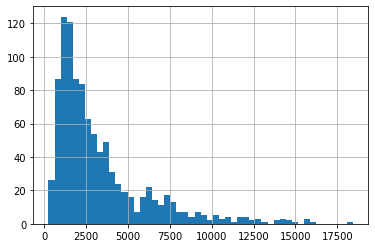

In [7]:
#check credit amount for outliers
german_data['Credit Amount'].hist(bins=50)
# x achse log 



<AxesSubplot:ylabel='Frequency'>

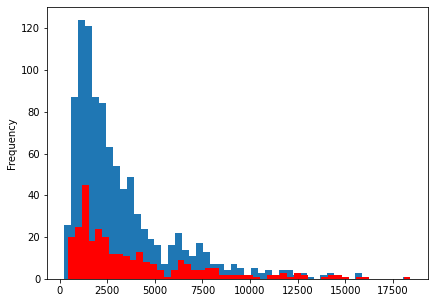

In [8]:
plt.subplot(1, 2, 1)
german_data['Credit Amount'].plot(kind='hist', logx=False, bins=50)
# plot histogram credit amout where target is 2
german_data.loc[german_data['Target'] == 2, 'Credit Amount'].plot(kind='hist', logx=False, bins=50, color='red', figsize=(15, 5))


<AxesSubplot:ylabel='Target'>

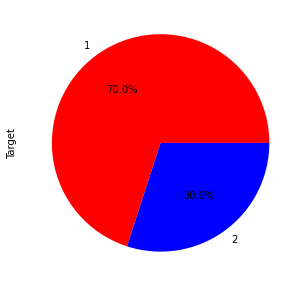

In [9]:
# plot target variable as pie chart with target 1 and target 2 as labels colored red and blue

german_data['Target'].value_counts().plot(kind='pie', colors=['red', 'blue'], autopct='%1.1f%%', figsize=(15, 5))

# Zielvariable ist Ungleichverteilt

# Untersuchung auf Outlier

<AxesSubplot:title={'center':'Credit Amount'}, xlabel='Target'>

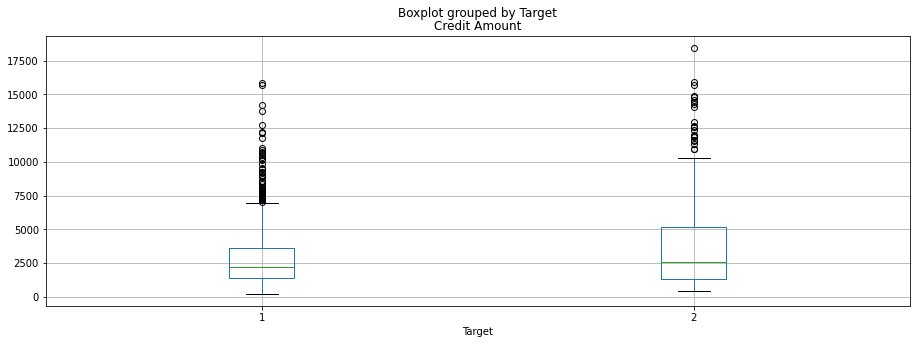

In [10]:
#box plot credit amount outliers
german_data.boxplot(column='Credit Amount', by='Target', figsize=(15, 5))

<AxesSubplot:xlabel='Credit Amount', ylabel='Target'>

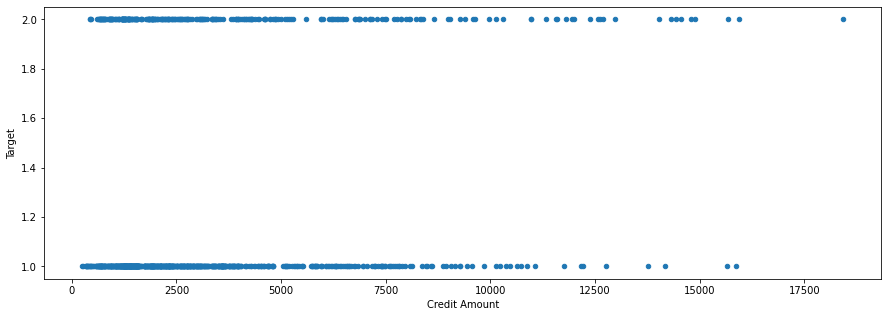

In [11]:
# scatter plot credit amount
german_data.plot(kind='scatter', x='Credit Amount', y='Target', figsize=(15, 5))

In [12]:
# calculate ZScore for credit amount
german_data['ZScore'] = (german_data['Credit Amount'] - german_data['Credit Amount'].mean()) / german_data['Credit Amount'].std()


<AxesSubplot:ylabel='Frequency'>

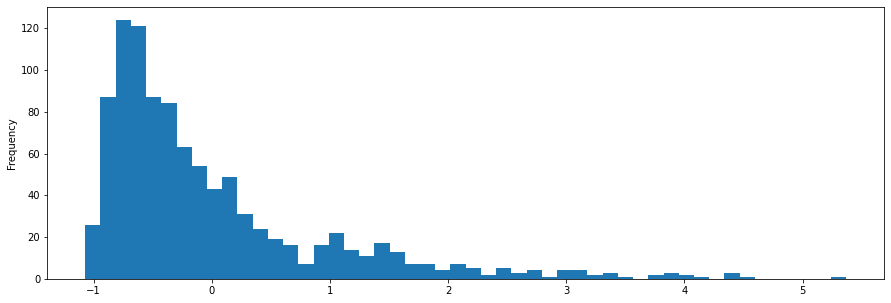

In [13]:
#plot zscore for credit amount
german_data['ZScore'].plot(kind='hist', bins=50, figsize=(15, 5))


In [14]:
# calculate IQR for credit amount
Q1 = np.percentile(german_data['Credit Amount'], 25,
                   interpolation = 'midpoint')
 
Q3 = np.percentile(german_data['Credit Amount'], 75,
                   interpolation = 'midpoint')
IQR = Q3 - Q1

upper = Q3 +1.5*IQR
lower = Q1 - 1.5*IQR
upper = german_data['Credit Amount'] >= (Q3+1.5*IQR)
 
print("Upper bound:",upper)
print(np.where(upper))
 
# Below Lower bound
lower = german_data['Credit Amount'] <= (Q1-1.5*IQR)
print("Lower bound:", lower)
print(np.where(lower))

Upper bound: 0      False
1      False
2      False
3      False
4      False
       ...  
995    False
996    False
997    False
998    False
999    False
Name: Credit Amount, Length: 1000, dtype: bool
(array([  5,  17,  18,  57,  63,  70,  78,  87,  95, 105, 130, 134, 136,
       180, 205, 226, 236, 268, 272, 274, 285, 291, 295, 304, 333, 373,
       374, 378, 381, 395, 402, 417, 431, 450, 491, 496, 509, 525, 549,
       563, 615, 616, 637, 645, 653, 657, 672, 684, 714, 736, 744, 763,
       771, 805, 808, 812, 818, 828, 832, 854, 881, 887, 895, 902, 915,
       917, 921, 927, 945, 953, 980, 983]),)
Lower bound: 0      False
1      False
2      False
3      False
4      False
       ...  
995    False
996    False
997    False
998    False
999    False
Name: Credit Amount, Length: 1000, dtype: bool
(array([], dtype=int64),)


/var/folders/rf/kg6tbnbs6md8psmvxmk30hmw0000gn/T/ipykernel_14165/3230260827.py:2: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they. (Deprecated NumPy 1.22)
  Q1 = np.percentile(german_data['Credit Amount'], 25,
/var/folders/rf/kg6tbnbs6md8psmvxmk30hmw0000gn/T/ipykernel_14165/3230260827.py:5: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they. (Deprecated NumPy 1.22)
  Q3 = np.percentile(german_data['Credit Amount'], 75,


In [15]:
# function to determine outlier values
def outlier_iqr(x):
    quartile_1, quartile_3 = np.percentile(x, [25, 75])
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    return np.where((x > upper_bound) | (x < lower_bound))
# calculate the outlier values
outlier_iqr(german_data['Credit Amount'])

(array([  5,  17,  18,  57,  63,  70,  78,  87,  95, 105, 130, 134, 136,
        180, 205, 226, 236, 268, 272, 274, 285, 291, 295, 304, 333, 373,
        374, 378, 381, 395, 402, 417, 431, 450, 491, 496, 509, 525, 549,
        563, 615, 616, 637, 645, 653, 657, 672, 684, 714, 736, 744, 763,
        771, 805, 808, 812, 818, 828, 832, 854, 881, 887, 895, 902, 915,
        917, 921, 927, 945, 953, 980, 983]),)

In [16]:
# transform target value 2 to 1 and 1 to 0 to be binary
german_data['Target'] = german_data['Target'].map({2:1, 1:0})


<AxesSubplot:>

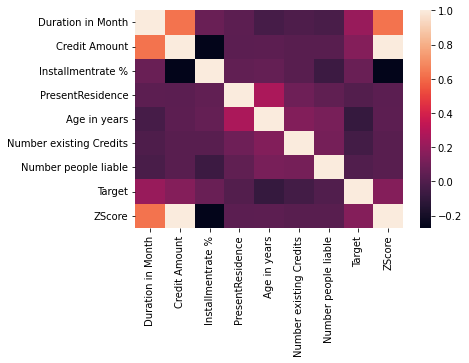

In [20]:
# check if feautures are correlated
corr = german_data.corr()
# plot correlation matrix
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns)


In [24]:
#iterate through feautures and get datatype and check if they are categorical or numerical and store them into list
categorical_features = []
numerical_features = []
for i in german_data.columns:
    print(i, german_data[i].dtype)
    if german_data[i].dtype == 'object':
        print(i, german_data[i].dtype)
        categorical_features.append(i)
    else:
        print(i, german_data[i].dtype)
        numerical_features.append(i)


print(categorical_features, "Numerical:" ,numerical_features)
    


Status Checking object
Status Checking object
Duration in Month int64
Duration in Month int64
Credit History object
Credit History object
Purpose object
Purpose object
Credit Amount int64
Credit Amount int64
Savings Account object
Savings Account object
Employement since object
Employement since object
Installmentrate % int64
Installmentrate % int64
StatusSex object
StatusSex object
Otherdebtos object
Otherdebtos object
PresentResidence int64
PresentResidence int64
Property object
Property object
Age in years int64
Age in years int64
Otherinstallment Plans object
Otherinstallment Plans object
Housing object
Housing object
Number existing Credits int64
Number existing Credits int64
Job object
Job object
Number people liable int64
Number people liable int64
Telephone object
Telephone object
Foreign Worker object
Foreign Worker object
Target int64
Target int64
ZScore float64
ZScore float64
['Status Checking', 'Credit History', 'Purpose', 'Savings Account', 'Employement since', 'StatusSex'

In [25]:
# one hot encode categorical features
german_data = pd.get_dummies(german_data, columns=categorical_features)


In [42]:
#drop zscore
german_data = german_data.drop(['ZScore'], axis=1)


In [75]:
# use logistic regression to predict target variable
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, fbeta_score

# split data into train and test set
X_train, X_test, y_train, y_test = train_test_split(german_data.drop('Target', axis=1), german_data['Target'], test_size=0.28, random_state=42)

# create logistic regression model
'''
solver to liblinear --> better score; standard lbfgs
'''
logreg = LogisticRegression(max_iter=100, intercept_scaling=100, solver = 'liblinear')
# fit the model
logreg.fit(X_train, y_train)
# predict the target variable
y_pred = logreg.predict(X_test)

# print accuracy score and recall score
print("Accuracy score:", accuracy_score(y_test, y_pred))
print("Recall score:", recall_score(y_test, y_pred))
print("Precision score:", precision_score(y_test, y_pred))
print("fbeta score:", fbeta_score(y_test, y_pred, beta=2))






Accuracy score: 0.7678571428571429
Recall score: 0.4880952380952381
Precision score: 0.6507936507936508
fbeta score: 0.5137844611528822


In [68]:
#hyperparameter tuning for logistic regression
from sklearn.model_selection import GridSearchCV
#tune hyperparameters
parameters = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'penalty': ['l1', 'l2'],'intercept_scaling': [100, 500, 1000, 5000, 10000]}
# create grid search object
grid_search = GridSearchCV(logreg, parameters, cv=5, scoring='accuracy')
# fit the model
grid_search.fit(X_train, y_train)
# print the best hyperparameters
print("Best hyperparameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)


Best hyperparameters: {'C': 10, 'intercept_scaling': 10000, 'penalty': 'l2'}
Best score: 0.75125


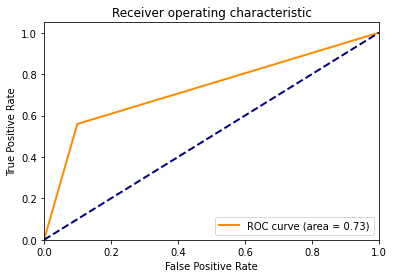

In [71]:
#plot roc curve
from sklearn.metrics import roc_curve, auc
#plot roc curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()


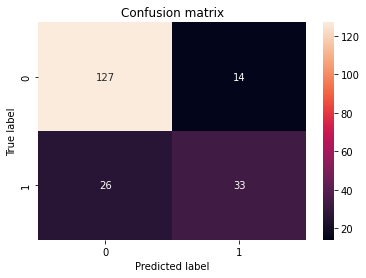

In [74]:
#plot confusion matrix
from sklearn.metrics import confusion_matrix

confusion_matrix = confusion_matrix(y_test, y_pred)
#plot confusion matrix with labels
plt.figure()
sns.heatmap(confusion_matrix, annot=True, fmt='d')
plt.title('Confusion matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()



